In [41]:
using LinearAlgebra
using Distributions
using Plots
using ColorSchemes

## Parametros de error instrumentos

Δt = 0.1

fs = 10
fs2 = 1
PSD_a = 80*10*1e-6
PSD_g = 0.03*π/180
PSD_m = 100e-6*1e-4
B_T = 25358e-9

err_IMU_x = PSD_a*sqrt(fs)
err_IMU_θ = PSD_g*sqrt(fs)

err_GPS = 2.5
err_MAG = PSD_m*sqrt(fs2)/B_T

Q = [err_IMU_x^2 0 0; 0 err_IMU_x^2 0; 0 0 err_IMU_θ^2]

R = [err_GPS^2 0 0; 0 err_GPS^2 0; 0 0 err_MAG^2]

dist_ruido_IMU = MvNormal([0,0,0], Q)
dist_ruido_GPS = MvNormal([0,0,0], R)


println(Q)
println(R)

[6.4000000000000006e-6 0.0 0.0; 0.0 6.4000000000000006e-6 0.0; 0.0 0.0 2.7415567780803773e-6]
[6.25 0.0 0.0; 0.0 6.25 0.0; 0.0 0.0 1.5551418366801118e-7]


In [43]:
# Generadores de datos 

function estatico_IMU()
    return [0,0,0]
end
function estatico_GPS()
    return [0,0,0]
end

estatico_GPS (generic function with 1 method)

In [44]:
## Matrices filtro Kalman

A = [1 Δt 0 0 0;
     0 1 0 0 0;
     0 0 1 Δt 0;
     0 0 0 1 0;
     0 0 0 0 1]

function B_matrix(θ)
    return [Δt^2*cos(θ)/2 -Δt^2*sin(θ)/2 0;
    Δt*cos(θ) -Δt*sin(θ) 0;
    Δt^2*sin(θ)/2 Δt^2*cos(θ)/2 0;
    Δt*sin(θ) Δt*cos(θ) 0;
    0 0 Δt]
end

H = [1 0 0 0 0;
     0 0 1 0 0;
     0 0 0 0 1]

3×5 Matrix{Int64}:
 1  0  0  0  0
 0  0  1  0  0
 0  0  0  0  1

In [45]:
function kalman_predict(x, u, P)
    B = B_matrix(x[5])
    x_est = A*x + B*u
    P_est = A*P*A' + B*Q*B'
    return x_est, P_est
end

function kalman_correct(x_prior, z, P_prior)
    K = P_prior*H'*inv(H*P_prior*H'+R)
    x_est = x_prior + K*(z-H*x_prior)
    P_est = (I-K*H)*P_prior
    return x_est, P_est, K
end

function kalman_initialize(t, tasa_GPS, z)
    N = length(t)
    x = zeros(5, N)
    x[1:2:5,1] = z[:,1]
    P = zeros(5, 5, N)
    P[:,:,1] = diagm([err_GPS^2,(err_GPS*fs2)^2,err_GPS^2,(err_GPS*fs2)^2,2pi])
    K = zeros(5, 3, N÷tasa_GPS)
    return x, P, K
end

function kalman(t, tasa_GPS, u, z)
    x, P, K = kalman_initialize(t, tasa_GPS, z)
    for k in 2:length(t)
        x_est, P_est = kalman_predict(x[:,k-1], u[:,k], P[:,:,k-1])
        if k%tasa_GPS == 0
            x_est, P_est, K_k = kalman_correct(x_est, z[:,k], P_est)
            K[:,:,k÷tasa_GPS] = K_k
        end
        x[:,k] = x_est
        P[:,:,k] = P_est
    end
    return x, P
end

kalman (generic function with 1 method)

In [ ]:
T = 500
t = 0:0.1:T

u_true = hcat([estatico_IMU() for ti in t]...)
u_noise = hcat([rand(dist_ruido_IMU) for ti in t]...)
z_true = hcat([estatico_GPS() for ti in t]...)
z_noise = hcat([rand(dist_ruido_GPS) for ti in t]...)
u = u_true + u_noise
z = z_true + z_noise
x, P = kalman(t, 10, u, z)

([-1.223787235880999 -1.22380275271364 … -0.17930100163669135 -0.1795083568166394; 0.0 -0.0003103366528196452 … -0.0018967979237825012 -0.002250305675178356; … ; 0.0 -0.00041613986353679247 … -0.0077613489996968725 -0.007801436660320887; -0.0002794640187689196 -0.00030817631756576455 … 2.2592111624671762e-5 -2.8431199440788638e-5], [6.25 0.0 … 0.0 0.0; 0.0 6.25 … 0.0 0.0; … ; 0.0 0.0 … 6.25 0.0; 0.0 0.0 … 0.0 6.283185307179586;;; 6.31250000016 0.6250000032 … 1.013290796118887e-28 0.0; 0.6250000032 6.250000064 … 2.4943584589793974e-28 0.0; … ; -7.088765594317273e-31 -4.395064373185345e-28 … 6.250000064 0.0; 0.0 0.0 … 0.0 6.283185334595154;;; 6.5000000016 1.2500000128000002 … 7.38064560983693e-29 0.0; 1.2500000128000002 6.250000128 … 9.772577152374617e-28 0.0; … ; -6.938253732913538e-29 9.258807670461116e-28 … 6.250000128 0.0; 0.0 0.0 … 0.0 6.283185362010721;;; … ;;; 0.15972719705013783 0.002020370544845382 … 3.8033289446895193e-25 0.0; 0.002020370544845382 5.0854141278523966e-5 … -1.920

In [48]:
function trayectoria_xy(x, z_true)
    p1 = plot(x[1,:], x[3,:], label="Estimación", xlabel="x", ylabel="y", aspect_ratio=:equal, title="Trayectoria XY")
    plot!(p1, z_true[1,:], z_true[2,:], label="Trayectoria")
    return p1
end

function trayectoria_t(t, x, z_true)
    p1 = plot(t, x[1,:], ylabel="x [m]", title="Trayectoria en función del tiempo")
    plot!(p1, t, z_true[1,:])
    p2 = plot(t, x[3,:], ylabel="y [m]")
    plot!(p2, t, z_true[2,:])
    p3 = plot(t, x[5,:] .% 2pi, ylabel="θ", xlabel="t [s]")
    plot!(p3, t, z_true[3,:] .% 2pi)
    return plot(p1,p2,p3, layout=(3,1), legend=false)
end

trayectoria_t (generic function with 1 method)

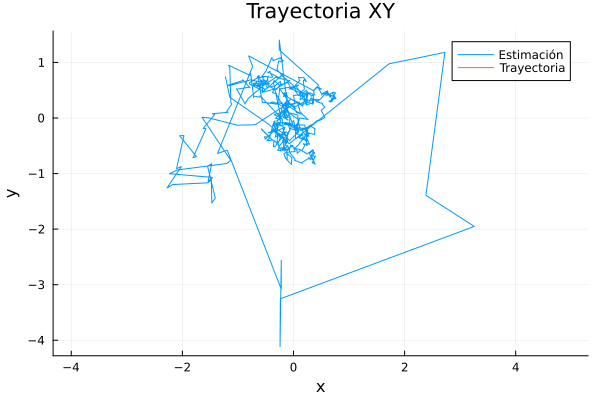

In [49]:
trayectoria_xy(x, z_true)

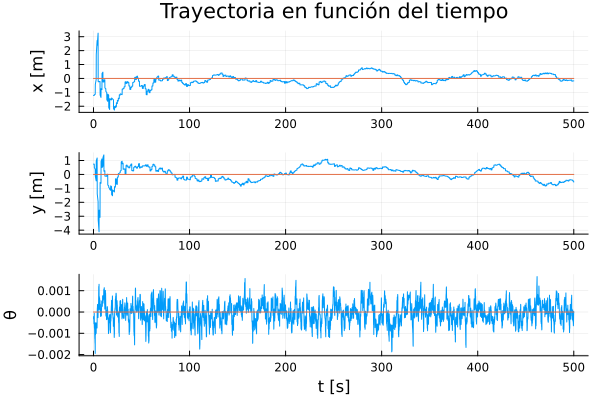

In [50]:
trayectoria_t(t, x, z_true)

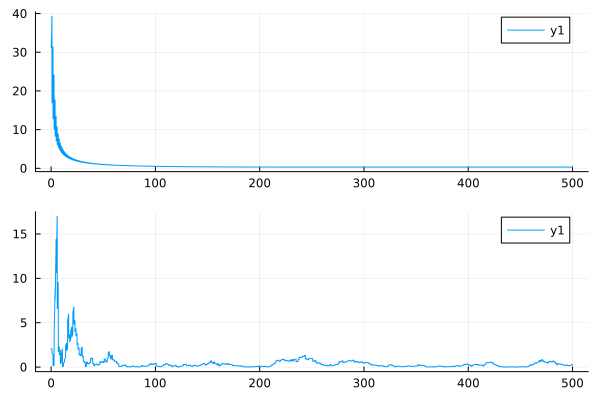

In [51]:
function varianza_estimador(P)
    return [tr(P[:,:,i]) for i in 1:size(P,3)]
end

function estimation_error(x, z_true)
    xs = [[x_i[1] x_i[3]] for x_i in eachcol(x)]
    zs = [[z_i[1] z_i[2]] for z_i in eachcol(z_true)]
    return [norm(x_i-z_i)^2 for (x_i, z_i) in zip(xs, zs)]
end

function plot_error(t, x, z_true, P)
    p1 = plot(t, varianza_estimador(P))
    p2 = plot(t, estimation_error(x, z_true))
    return plot(p1, p2, layout=(2,1))
end

plot_error(t, x, z_true, P)

In [52]:
# Generadores de datos 

function mru_IMU()
    return [0,0,0]
end
function mru_GPS(v, t, θ)
    return [v*t*cos(θ),v*t*sin(θ),θ]
end

mru_GPS (generic function with 1 method)

In [53]:
t_gps = t[1:10:end]

u_true = hcat([estatico_IMU() for ti in t]...)
z_true = hcat([mru_GPS(100/T, ti, pi/4) for ti in t]...)

u = u_true + u_noise
z = z_true + z_noise

x, P = kalman(t, 10, u, z)

([-1.223787235880999 -1.2237834951726105 … 70.58344470989839 70.59774251957364; 0.0 7.481416776940403e-5 … 0.143088907488292 0.14286728601674714; … ; 0.0 -0.0005136964710884169 … 0.13551697562445592 0.13523866163957277; 0.7851186993786794 0.7850899870798825 … 0.785420755509073 0.7853697321980075], [6.25 0.0 … 0.0 0.0; 0.0 6.25 … 0.0 0.0; … ; 0.0 0.0 … 6.25 0.0; 0.0 0.0 … 0.0 6.283185307179586;;; 6.31250000016 0.6250000032 … 1.1092301608009414e-25 0.0; 0.6250000032 6.250000064 … 3.9049200030955144e-25 0.0; … ; 1.9507123971656156e-25 1.1683928264965458e-24 … 6.250000064 0.0; 0.0 0.0 … 0.0 6.283185334595154;;; 6.5000000016 1.2500000128000002 … -3.719139900271429e-26 0.0; 1.2500000128000002 6.250000128 … 8.275884030191062e-25 0.0; … ; 8.750696298758388e-26 4.391923111483954e-25 … 6.250000128 0.0; 0.0 0.0 … 0.0 6.283185362010721;;; … ;;; 0.15972719705013783 0.002020370544845382 … -1.8807255502262903e-21 0.0; 0.002020370544845382 5.0854141278523966e-5 … -6.360334456139304e-23 0.0; … ; 1.6754

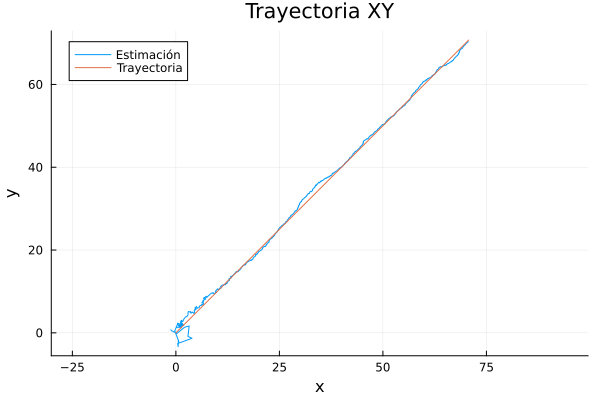

In [54]:
trayectoria_xy(x, z_true)

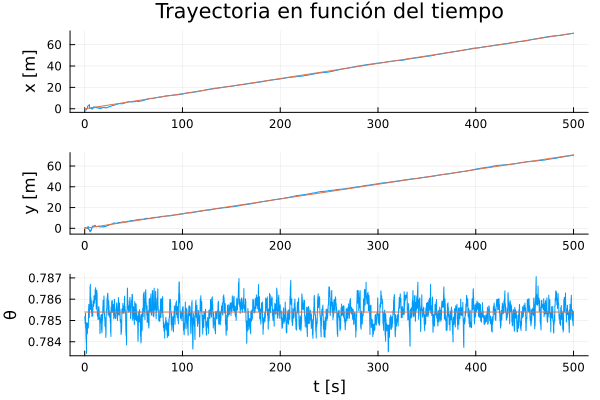

In [55]:
trayectoria_t(t, x, z_true)

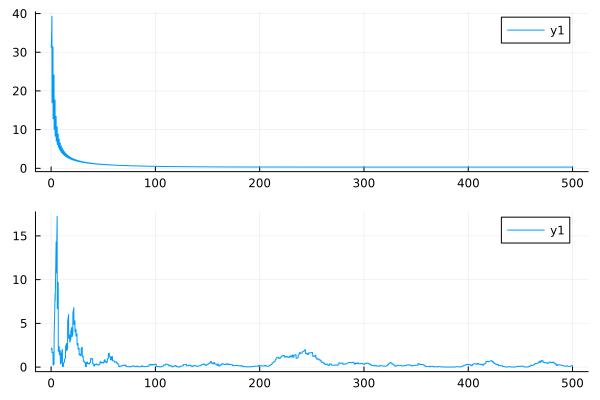

In [56]:

plot_error(t, x, z_true, P)

In [57]:
# Generadores de datos 

function circular_IMU(r, w, t)
    return [0,w^2*r,w] 
end

function circular_GPS(r, w, t)
    return [r*cos(w*t),r*sin(w*t),w*t+π/2] 
end

u_true = hcat([circular_IMU(20, 2*pi/T, ti) for ti in t]...)
z_true = hcat([circular_GPS(20, 2*pi/T, ti) for ti in t]...)

u = u_true + u_noise
z = z_true + z_noise

3×5001 Matrix{Float64}:
 18.7762    19.9011   24.5303    22.248    …  19.5701   19.6944   20.2105
  0.739645  -3.65581  -0.937314   2.46585      2.6014   -3.40718  -2.94765
  1.57052    1.57188   1.57352    1.57431      7.85118   7.85282   7.85396

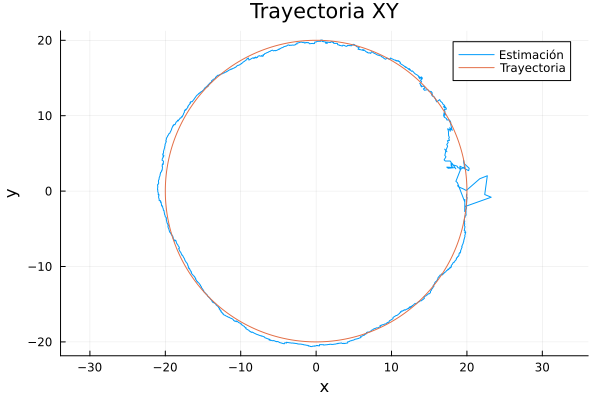

In [58]:
x, P = kalman(t, 10, u, z)

trayectoria_xy(x, z_true)

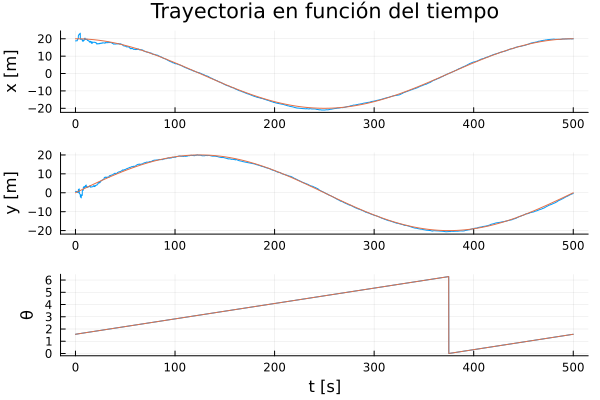

In [59]:
trayectoria_t(t, x, z_true)

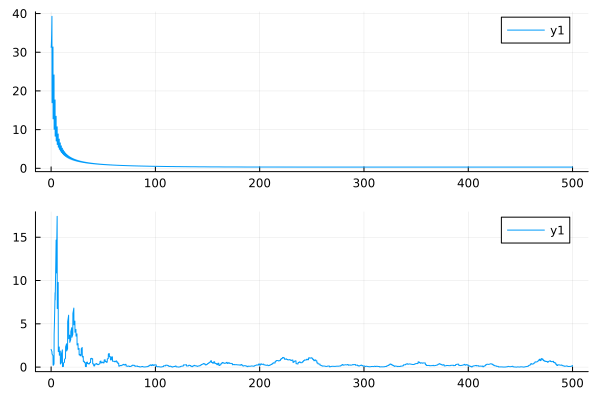

In [60]:

plot_error(t, x, z_true, P)